<a href="https://colab.research.google.com/github/Iallen520/lhy_DL_Hw/blob/master/hw4_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download Dataset
有三個檔案，分別是training_label.txt、training_nolabel.txt、testing_data.txt

training_label.txt：有label的training data(句子配上0 or 1)

training_nolabel.txt：沒有label的training data(只有句子)，用來做semi-supervise learning

testing_data.txt：你要判斷testing data裡面的句子是0 or 1

In [1]:
# this is for filtering the warnings

#import warnings
#warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

df = pd.read_csv("unlabeledTrainData.tsv",sep = "\t",error_bad_lines=False)
df

b'Skipping line 43043: expected 2 fields, saw 3\n'


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."
...,...,...
49993,18984_0,The original Man Eater by Joe D'Amato is somew...
49994,16433_0,When Home Box Office was in it's early days mo...
49995,16006_0,Griffin Dunne was born into a cultural family....
49996,40155_0,"Not a bad story, but the low budget rears its ..."


### Utils

In [58]:
# utils.py
# 這個block用來先定義一些等等常用到的函式
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F


label_train_path = "labeledTrainData.tsv"
unlabel_train_path = "unlabeledTrainData.tsv"
test_path = "testData.tsv"

def load_training_data(path='labeledTrainData.tsv'):  
    #global x,y
    # 把training時需要的data讀進來
    # 如果是'training_labe|l.txt'，需要讀取label，如果是'training_nolabel.txt'，不需要讀取label
    if(path == "labeledTrainData.tsv"):
        df = pd.read_csv("labeledTrainData.tsv",sep = "\t")
        #display(df.head())
        x = df['review'].apply(lambda x: x.strip().split(" "))
        x = list(x)
        y = df["sentiment"]  #二维的list
        y = list(y)   #一维的list
        return x, y
    else:
        df = pd.read_csv("unlabeledTrainData.tsv",sep = "\t",error_bad_lines=False)
        x = df['review'].apply(lambda x: x.strip().split(" "))
        x = list(x)
        return x
    

def load_testing_data(path='testData.tsv'):   #约55万
    # 把testing時需要的data讀進來
    df = pd.read_csv("testData.tsv",sep = "\t")
    #display(df.head())
    x = df['review'].apply(lambda x: x.strip().split(" "))
    x = list(x)
    return x  # X形如[["i","am","here"], ["he","loves","it"]]


def evaluation(outputs, labels):
    #outputs => probability (float)
    #labels => labels
    outputs[outputs>=0.5] = 1 # 大於等於0.5為有惡意
    outputs[outputs<0.5] = 0 # 小於0.5為無惡意
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct


### Train Word to Vector

In [108]:
train_x, y = load_training_data(label_train_path)
average_sentence_length = 0
for sen in train_x:
    average_sentence_length += len(sen)
average_sentence_length /= len(train_x)
print("训练集平均句子长度：",average_sentence_length)

训练集平均句子长度： 233.78624


In [117]:
# w2v.py
# 這個block是用來訓練word to vector 的 word embedding
# 注意！這個block在訓練word to vector時是用cpu，可能要花到10分鐘以上
import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

path_prefix = "./"

def train_word2vec(x):
    # 訓練word to vector 的 word embedding
    model = word2vec.Word2Vec(x, size=250, window=5, min_count=5, workers=12, iter=10, sg=1)
    return model

if __name__ == "__main__":
    l = os.listdir()
    if "w2v_all.model" not in l:   
        print("loading training data ...")
        train_x, y = load_training_data(label_train_path)
        train_x_no_label = load_training_data(unlabel_train_path)

        print("loading testing data ...")
        test_x = load_testing_data(test_path)

        model = train_word2vec(train_x + train_x_no_label + test_x)

        print("saving model ...")
        # model.save(os.path.join(path_prefix, 'model/w2v_all.model'))
        model.save(os.path.join(path_prefix, 'w2v_all.model'))

### Data Preprocess

In [118]:
# preprocess.py
# 這個block用來做data的預處理
from torch import nn
from gensim.models import Word2Vec

class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # 把之前訓練好的word to vec 模型讀進來
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # 把word加進embedding，並賦予他一個隨機生成的representation vector
        # word只會是"<PAD>"或"<UNK>"
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        # 取得訓練好的 Word2vec word embedding
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError
        # 製作一個 word2idx 的 dictionary
        # 製作一個 idx2word 的 list
        # 製作一個 word2vector 的 list
        for i, word in enumerate(self.embedding.wv.vocab):
            print('get words #{}'.format(i+1), end='\r')
            #e.g. self.word2index['魯'] = 1 
            #e.g. self.index2word[1] = '魯'
            #e.g. self.vectors[1] = '魯' vector
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        # 將"<PAD>"跟"<UNK>"加進embedding裡面
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        # 將每個句子變成一樣的長度
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        # 把句子裡面的字轉成相對應的index
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            # 將每個句子變成一樣的長度
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # 把labels轉成tensor
        y = [int(label) for label in y]
        
        return torch.LongTensor(y)


### Dataset

In [119]:
# data.py
# 實作了dataset所需要的'__init__', '__getitem__', '__len__'
# 好讓dataloader能使用
import torch
from torch.utils import data

class TwitterDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

### Model

In [148]:
# model.py
# 這個block是要拿來訓練的模型
import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix住，如果fix_embedding為False，在訓練過程中，embedding也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

### Train

In [155]:
# train.py
# 這個block是用來訓練模型的
%matplotlib inline

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys

yy_train_loss=[]
yy_valid_loss = []
yy_train_acc = []
yy_valid_acc = []
xx = []
early_stopping_epoch = 30
add_num = 0
total_loss, total_acc = 0,0
best_acc = 0
pre_valid_loss = 100000

def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):
    global add_num,total_loss,total_acc,best_acc,pre_valid_loss
    
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))
    model.train() # 將model的模式設為train，這樣optimizer就可以更新model的參數
    criterion = nn.BCELoss() # 定義損失函數，這裡我們使用binary cross entropy loss
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9) # 將模型的參數給optimizer，並給予適當的learning rate
    total_loss, total_acc, best_acc = 0, 0, 0
    for epoch in range(n_epoch):
        xx.append(epoch)
        
        total_loss, total_acc = 0, 0
        # 這段做training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # device為"cuda"，將inputs轉成torch.cuda.LongTensor
            labels = labels.to(device, dtype=torch.float) # device為"cuda"，將labels轉成torch.cuda.FloatTensor，因為等等要餵進criterion，所以型態要是float
            optimizer.zero_grad() # 由於loss.backward()的gradient會累加，所以每次餵完一個batch後需要歸零
            outputs = model(inputs) # 將input餵給模型
            outputs = outputs.squeeze() # 去掉最外面的dimension，好讓outputs可以餵進criterion()
            loss = criterion(outputs, labels) # 計算此時模型的training loss
            loss.backward() # 算loss的gradient
            optimizer.step() # 更新訓練模型的參數
            correct = evaluation(outputs, labels) # 計算此時模型的training accuracy
            total_acc += (correct / batch_size)
            total_loss += loss.item()
            print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
            	epoch+1, i+1, t_batch, loss.item(), correct*100/batch_size), end='\r')
        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss/t_batch, total_acc/t_batch*100))
        yy_train_loss.append(total_loss/t_batch)
        yy_train_acc.append(total_acc/t_batch*100)
        
        
        # 這段做validation
        model.eval() # 將model的模式設為eval，這樣model的參數就會固定住
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) # device為"cuda"，將inputs轉成torch.cuda.LongTensor
                labels = labels.to(device, dtype=torch.float) # device為"cuda"，將labels轉成torch.cuda.FloatTensor，因為等等要餵進criterion，所以型態要是float
                outputs = model(inputs) # 將input餵給模型
                outputs = outputs.squeeze() # 去掉最外面的dimension，好讓outputs可以餵進criterion()
                loss = criterion(outputs, labels) # 計算此時模型的validation loss
                correct = evaluation(outputs, labels) # 計算此時模型的validation accuracy
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            yy_valid_loss.append(total_loss/v_batch)
            yy_valid_acc.append(total_acc/v_batch*100)
            
            # early stopping,连续增长到early_stopping_epoch轮数的话，就会提前终止epoch循环,epoch = sys.maxsize
            curr_valid_loss = total_loss/v_batch
            
            if(curr_valid_loss > pre_valid_loss):
                add_num += 1
                if(add_num == early_stopping_epoch):
                    epoch = sys.maxsize
            else:
                add_num = 0
                
            pre_valid_loss = curr_valid_loss
            
                        
            if total_acc/v_batch > best_acc:
                print("total_acc/v_batch:",total_acc/v_batch)
                
                # 如果validation的結果優於之前所有的結果，就把當下的模型存下來以備之後做預測時使用
                best_acc = total_acc/v_batch
                
                
                #torch.save(model, "{}/val_acc_{:.3f}.model".format(model_dir,total_acc/v_batch*100))
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(total_acc/v_batch*100))
        print('-----------------------------------------------')
        model.train() # 將model的模式設為train，這樣optimizer就可以更新model的參數（因為剛剛轉成eval模式）
    #结束for循环
    
    #将最好的valid的best_acc存放下来
    tt_path = str(best_acc) +"_best_acc.txt"
    with open(tt_path,"w") as f:
        f.write(str(best_acc))
    
    
    ax1 = plt.subplot(1,2,1)
    plt.sca(ax1)
    plt.plot(xx,yy_train_loss,"r",label = "train_loss")
    plt.plot(xx,yy_valid_loss,"b",label = "valid_loss")
    plt.legend()
    ax2 = plt.subplot(1,2,2)
    plt.sca(ax2)
    plt.plot(xx,yy_train_acc,"y",label = "train_acc")
    plt.plot(xx,yy_valid_acc,"g",label = "valid_acc")
    plt.legend()
    
    print("over")

### Test

In [156]:
# test.py
# 這個block用來對testing_data.txt做預測
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            #outputs[outputs>=0.5] = 1 # 大於等於0.5為負面
            #outputs[outputs<0.5] = 0 # 小於0.5為正面
            ret_output += outputs.float().tolist()
    
    return ret_output

### Main

loading data ...
Get embedding ...
loading word to vec model ...


/home/u2019101432/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


get words #121343
total words: 121345
sentence count #25000
start training, parameter total:30838501, trainable:502251

[ Epoch1: 157/157 ] loss:0.667 acc:15.625 
Train | Loss:0.69236 Acc: 51.752
Valid | Loss:0.68167 Acc: 53.867 
total_acc/v_batch: 0.538671875
saving model with acc 53.867
-----------------------------------------------


/home/u2019101432/.conda/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/u2019101432/.conda/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/u2019101432/.conda/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/u2019101432/.conda/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked

[ Epoch2: 157/157 ] loss:0.671 acc:15.625 
Train | Loss:0.69209 Acc: 52.135
Valid | Loss:0.67559 Acc: 57.363 
total_acc/v_batch: 0.5736328125
saving model with acc 57.363
-----------------------------------------------
[ Epoch3: 157/157 ] loss:0.643 acc:15.625 
Train | Loss:0.67353 Acc: 57.016
Valid | Loss:0.68321 Acc: 53.164 
-----------------------------------------------
[ Epoch4: 157/157 ] loss:0.676 acc:14.844 
Train | Loss:0.68160 Acc: 56.240
Valid | Loss:0.69029 Acc: 50.273 
-----------------------------------------------
[ Epoch5: 157/157 ] loss:0.540 acc:19.531 
Train | Loss:0.65946 Acc: 61.709
Valid | Loss:0.56751 Acc: 77.656 
total_acc/v_batch: 0.7765625
saving model with acc 77.656
-----------------------------------------------
[ Epoch6: 157/157 ] loss:0.445 acc:22.656 
Train | Loss:0.66218 Acc: 59.395
Valid | Loss:0.53424 Acc: 77.051 
-----------------------------------------------
[ Epoch7: 157/157 ] loss:0.749 acc:7.812 
Train | Loss:0.66892 Acc: 57.738
Valid | Loss:0.6

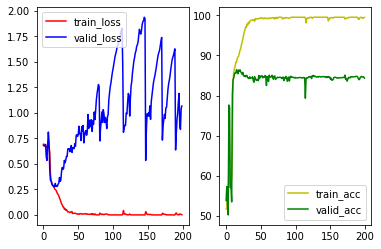

In [157]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

# 通過torch.cuda.is_available()的回傳值進行判斷是否有使用GPU的環境，如果有的話device就設為"cuda"，沒有的話就設為"cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 處理好各個data的路徑

#  label_train_path = "labeledTrainData.tsv"
#  unlabel_train_path = "unlabeledTrainData.tsv"
#  test_path = "testData.tsv"
train_with_label = os.path.join(path_prefix, label_train_path)
train_no_label = os.path.join(path_prefix, unlabel_train_path)
testing_data = os.path.join(path_prefix, test_path)

w2v_path = os.path.join(path_prefix, 'w2v_all.model') # 處理word to vec model的路徑

# 定義句子長度、要不要固定embedding、batch大小、要訓練幾個epoch、learning rate的值、model的資料夾路徑
sen_len = 200
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 200
lr = 0.001
# model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
model_dir = path_prefix # model directory for checkpoint model

print("loading data ...") # 把'training_label.txt'跟'training_nolabel.txt'讀進來
train_x, y = load_training_data(label_train_path)
#train_x_no_label = load_training_data(train_no_label)

# 對input跟labels做預處理
preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)

# 製作一個model的對象
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=250, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device) # device為"cuda"，model使用GPU來訓練(餵進去的inputs也需要是cuda tensor)

# 把data分為training data跟validation data(將一部份training data拿去當作validation data)
p = 0.8
split_num = int(len(train_x)*p)
X_train, X_val, y_train, y_val = train_x[:split_num], train_x[split_num:], y[:split_num], y[split_num:]

# 把data做成dataset供dataloader取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

# 開始訓練
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

over


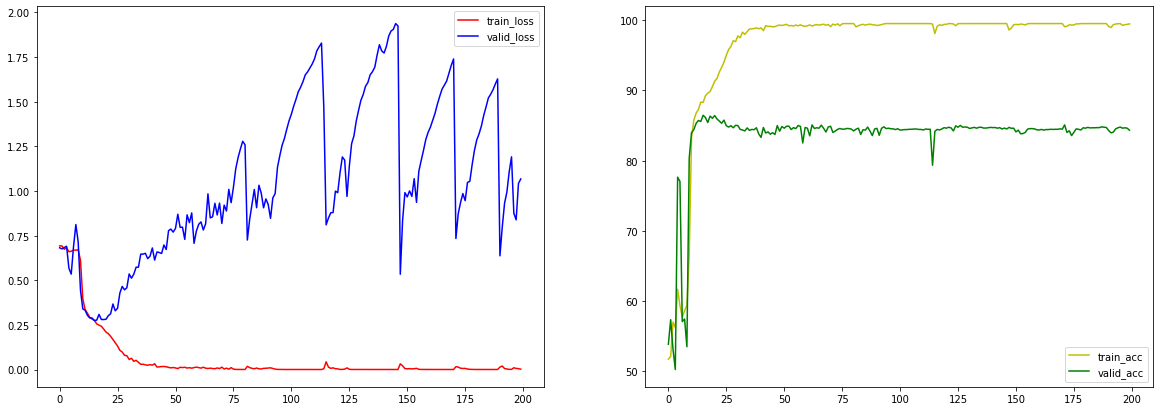

In [163]:
fig=plt.figure(figsize=(20,7))
ax1 = plt.subplot(1,2,1)
plt.sca(ax1)
plt.plot(xx,yy_train_loss,"r",label = "train_loss")
plt.plot(xx,yy_valid_loss,"b",label = "valid_loss")
plt.legend()
ax2 = plt.subplot(1,2,2)
plt.sca(ax2)
plt.plot(xx,yy_train_acc,"y",label = "train_acc")
plt.plot(xx,yy_valid_acc,"g",label = "valid_acc")
plt.legend()

plt.savefig("Adam_lr0.001_200epoch.png")
print("over")

### Predict and Write to csv file

In [159]:
# 開始測試模型並做預測
print("loading testing data ...")
test_x = load_testing_data(testing_data)
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = TwitterDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)


# 以下是使用command line上傳到kaggle的方式
# 需要先pip install kaggle、Create API Token，詳細請看https://github.com/Kaggle/kaggle-api以及https://www.kaggle.com/code1110/how-to-submit-from-google-colab
# kaggle competitions submit [competition-name] -f [csv file path]] -m [message]
# ex: kaggle competitions submit ml-2020spring-hw4 -f output/predict.csv -m "......"

loading testing data ...
Get embedding ...
loading word to vec model ...


/home/u2019101432/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


get words #121343
total words: 121345
sentence count #25000
load model ...


In [160]:
df = pd.read_csv("testData.tsv",sep = "\t",error_bad_lines=False)
kk = list(df["id"])

# 寫到csv檔案供上傳kaggle
tmp = pd.DataFrame({"id":kk,"sentiment":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'result_predict.csv'), index=False)
print("Finish Predicting")


save csv ...
Finish Predicting


In [161]:
print("over")

over


#### Check where the files are

In [162]:
!pwd
!ls

/home/u2019101432/jupyterlab/kaggle_IMDB_sentiment_classificationassi
0.8490234375_best_acc.txt	 t2.png
0.8646484375_best_acc.txt	 testData.tsv
Adam_lr0.001_200epoch.png	 testData.tsv.zip
Untitled.ipynb			 tl.png
ckpt.model			 unlabeledTrainData.tsv
labeledTrainData.tsv		 unlabeledTrainData.tsv.zip
labeledTrainData.tsv.zip	 w2v_all.model
result_predict.csv		 w2v_all.model.trainables.syn1neg.npy
sampleSubmission.csv		 w2v_all.model.wv.vectors.npy
sentimenti_classification.ipynb  word2vec-nlp-tutorial.zip


### Run 20 epochs on n98
real	3m33.317s

user	3m29.813s

sys	1m9.469s